# APS360 Project

1. Load and split data for training, validation and testing
2. Creating Generator
3. Creating Discriminator
4. Training



## Part A. Data Loading

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import os
import shutil
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn.utils import spectral_norm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 4
LEARNING_RATE = 0.0002
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"

transforms = A.Compose(
    [
        A.Resize(width=128, height=128),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


### 0. Helper Functions ###

In [40]:
###############################################################################
# Data Loading
import os
import random
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler

class ImageBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer"
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


class AnimeHumanImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)  # Convert to NumPy array for albumentations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, 0  # Since there are no labels, we can return a dummy label (0)
    

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    """
    Creates a subset of the original dataset.
    
    Args:
        original_dir (str): Path to the original dataset directory.
        subset_dir (str): Path to the subset dataset directory.
        subset_size (int): Number of images to include in the subset.
    """
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    # Get all image paths
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    # Shuffle and select a subset
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    # Copy images to the subset directory
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(128, 128), subset_size=None):
   # Define the transformation
    transform = A.Compose([
        A.Resize(width=image_size[0], height=image_size[1]),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ])
    
    # Verify the path
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    # Load the dataset
    dataset = AnimeHumanImageDataset(root_dir=data_dir, transform=transform)

    # Use a subset of the dataset if specified
    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler, num_workers=1)
        return loader

    # Function to split dataset indices
    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)  # Setting a seed for reproducibility
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    # Get split indices for the dataset
    train_indices, val_indices, test_indices = split_indices(dataset)

    # Create data loaders
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, path_prefix):
    np.savetxt(f"{path_prefix}_train_loss_anime.csv", train_loss_anime_history)
    np.savetxt(f"{path_prefix}_train_loss_human.csv", train_loss_human_history)
    np.savetxt(f"{path_prefix}_val_loss_anime.csv", val_loss_anime_history)
    np.savetxt(f"{path_prefix}_val_loss_human.csv", val_loss_human_history)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

### 1.1 Load Data ###

In [41]:
# Use (1000k photos) smaller subsets for quick testing
create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetA_10k', 'data/subset_dataSetA', subset_size=100)
create_subset_dataset('/home/jempio/documents/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=100)

# Load data from the subsets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('data/subset_dataSetA', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

Subset created with 100 images in data/subset_dataSetA
Subset created with 100 images in data/subset_dataSetB


In [32]:
# # Load data from the full datasets
# train_loader_A, val_loader_A, test_loader_A = get_data_loader('/home/jempio/documents/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
# train_loader_B, val_loader_B, test_loader_B = get_data_loader('/home/jempio/documents/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

### 1.2 Verifying Split and Overlap ###

In [42]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 1000
Dataset A - Train examples: 700 (70.00%)
Dataset A - Validation examples: 150 (15.00%)
Dataset A - Test examples: 150 (15.00%)
Dataset B - Total examples: 1000
Dataset B - Train examples: 700 (70.00%)
Dataset B - Validation examples: 150 (15.00%)
Dataset B - Test examples: 150 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


### 1.3 Visualize Data ###

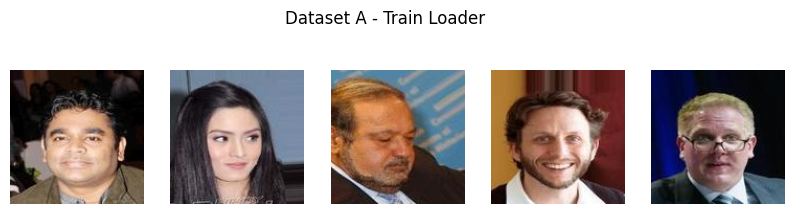

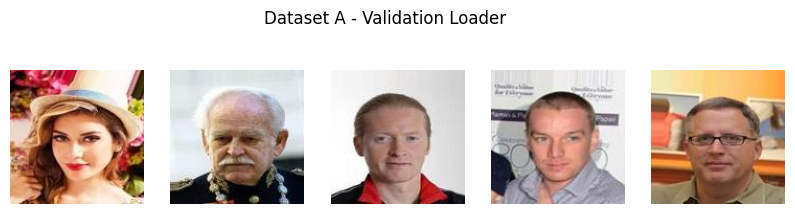

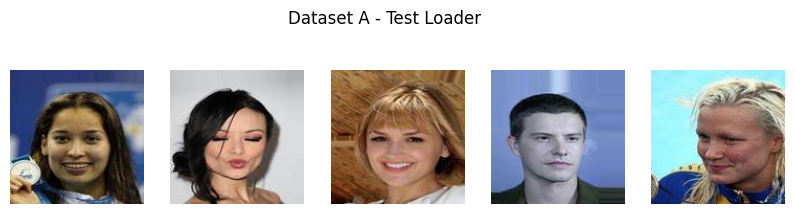

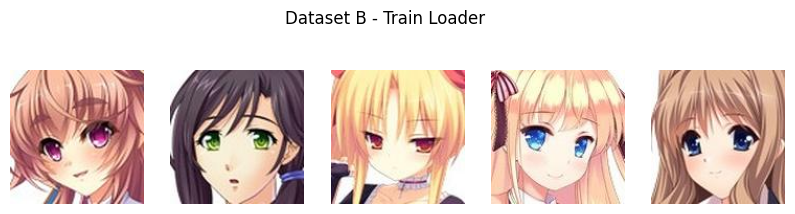

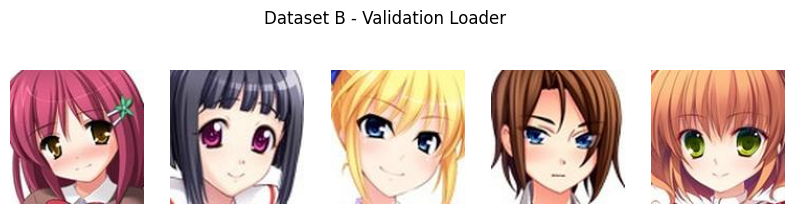

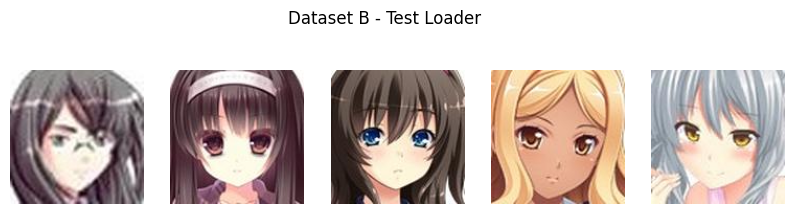

In [43]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=5):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

## Convolutional Block

In [35]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                spectral_norm(nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )
        else:
            self.conv = nn.Sequential(
                spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, **kwargs)),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(inplace=True) if add_activation else nn.Identity(),
                nn.Dropout(0.5)
            )

    def forward(self, x):
        return self.conv(x)


In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
     
        return x + self.block(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, img_channels: int, num_features: int = 64, num_residuals: int = 9):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features, 
                    num_features * 2,
                    is_downsampling=True, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 8,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 8) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 8,
                    num_features * 4,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

In [12]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [13]:
class MiniBatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims=5):
        super(MiniBatchDiscrimination, self).__init__()
        self.out_features = out_features
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dims))

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the tensor

        # Compute matrix multiplication
        M = x.mm(self.T.view(x.size(1), -1))
        M = M.view(batch_size, self.out_features, self.T.size(2))

        # Compute L1 distance between each pair of samples in the batch
        out = M.unsqueeze(0) - M.unsqueeze(1)
        out = torch.exp(-torch.sum(torch.abs(out), dim=3))

        # Sum over the kernel dimensions
        out = out.sum(dim=2)

        return torch.cat([x, out], dim=1)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            spectral_norm(nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            )),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels, 
                    feature, 
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output 
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)
        #self.mb_discriminator = MiniBatchDiscrimination(in_features=in_channels*4*4, out_features=100)

    def forward(self, x):
        x = self.initial_layer(x)
        #x = self.mb_discriminator(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [29]:
import os
import numpy as np
import torch
from torchvision.utils import save_image
from tqdm import tqdm

def train_fn(disc_human, disc_anime, gen_anime, gen_human, train_loader_A, train_loader_B, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, num_epochs=1, start_epoch=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fake_A_buffer = ImageBuffer()
    fake_B_buffer = ImageBuffer()
    
    train_loss_anime_history = []
    train_loss_human_history = []
    val_loss_anime_history = []
    val_loss_human_history = []

    # Ensure the outputs directory exists
    os.makedirs('outputs', exist_ok=True)

    for epoch in range(num_epochs):
        current_epoch = start_epoch + epoch
        print(f"Epoch [{current_epoch + 1}/{start_epoch + num_epochs}]")
        epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")

        total_train_loss_anime = 0.0
        total_train_loss_human = 0.0
        total_batches = 0

        H_reals = 0
        H_fakes = 0

        for idx, ((human, _), (anime, _)) in enumerate(epoch_loop):
            human = human.to(device)
            anime = anime.to(device)

            # Train Discriminators Anime and Human
            with torch.cuda.amp.autocast():
                fake_anime = gen_anime(human)
                D_anime_real = disc_anime(anime)
                fake_anime = fake_A_buffer.push_and_pop(fake_anime)
                D_anime_fake = disc_anime(fake_anime.detach())
                H_reals += D_anime_real.mean().item()
                H_fakes += D_anime_fake.mean().item()
                anime_real_loss = mse(D_anime_real, torch.ones_like(D_anime_real))
                anime_fake_loss = mse(D_anime_fake, torch.zeros_like(D_anime_fake))
                D_anime_loss = anime_real_loss + anime_fake_loss

                fake_human = gen_human(anime)
                D_human_real = disc_human(human)
                fake_human = fake_B_buffer.push_and_pop(fake_human)
                D_human_fake = disc_human(fake_human.detach())
                human_real_loss = mse(D_human_real, torch.ones_like(D_human_real))
                human_fake_loss = mse(D_human_fake, torch.zeros_like(D_human_fake))
                D_human_loss = human_real_loss + human_fake_loss

                D_loss = (D_anime_loss + D_human_loss) / 2

            opt_disc.zero_grad()
            d_scaler.scale(D_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()

            # Train Generators Anime and Human
            with torch.cuda.amp.autocast():
                # Adversarial losses
                D_anime_fake = disc_anime(fake_anime)
                D_human_fake = disc_human(fake_human)
                loss_G_anime = mse(D_anime_fake, torch.ones_like(D_anime_fake))
                loss_G_human = mse(D_human_fake, torch.ones_like(D_human_fake))

                # Cycle losses
                cycle_human = gen_human(fake_anime)
                cycle_anime = gen_anime(fake_human)
                cycle_human_loss = l1(human, cycle_human)
                cycle_anime_loss = l1(anime, cycle_anime)

                # Identity losses (optional)
                identity_human = gen_human(human)
                identity_anime = gen_anime(anime)
                identity_human_loss = l1(human, identity_human)
                identity_anime_loss = l1(anime, identity_anime)

                # Total loss
                G_loss = (
                    loss_G_anime
                    + loss_G_human
                    + cycle_human_loss * LAMBDA_CYCLE
                    + cycle_anime_loss * LAMBDA_CYCLE
                    + identity_anime_loss * LAMBDA_IDENTITY
                    + identity_human_loss * LAMBDA_IDENTITY
                )

            opt_gen.zero_grad()
            g_scaler.scale(G_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()

            # Save images more frequently
            if idx % 50 == 0:  # Save every 50 iterations
                save_image(fake_anime * 0.5 + 0.5, f"outputs/fake_anime_{current_epoch}_{idx}.png")
                save_image(fake_human * 0.5 + 0.5, f"outputs/fake_human_{current_epoch}_{idx}.png")

            # Update iteration progress bar
            epoch_loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item(), H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
            epoch_loop.update(1)

            # Accumulate training losses
            total_train_loss_anime += loss_G_anime.item()
            total_train_loss_human += loss_G_human.item()
            total_batches += 1

        epoch_loop.close()

        # Calculate average training losses
        avg_train_loss_anime = total_train_loss_anime / total_batches
        avg_train_loss_human = total_train_loss_human / total_batches

        # Evaluate models
        val_loss_anime = evaluate(gen_anime, disc_anime, val_loader_A, mse, device)
        val_loss_human = evaluate(gen_human, disc_human, val_loader_B, mse, device)
        
        # Print epoch summary
        print(f"Epoch {current_epoch + 1}: Train Loss Anime: {avg_train_loss_anime}, Train Loss Human: {avg_train_loss_human}, Validation Loss Anime: {val_loss_anime}, Validation Loss Human: {val_loss_human}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(gen_anime, opt_gen, filename=get_model_name("gen_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(gen_human, opt_gen, filename=get_model_name("gen_human", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_anime, opt_disc, filename=get_model_name("disc_anime", current_epoch, LEARNING_RATE, BATCH_SIZE))
        save_checkpoint(disc_human, opt_disc, filename=get_model_name("disc_human", current_epoch, LEARNING_RATE, BATCH_SIZE))

        print(f"Epoch {current_epoch + 1} checkpoint saved.")

        # Save training and validation losses
        train_loss_anime_history.append(avg_train_loss_anime)
        train_loss_human_history.append(avg_train_loss_human)
        val_loss_anime_history.append(val_loss_anime)
        val_loss_human_history.append(val_loss_human)


    save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, 
                get_model_name("loss", current_epoch, LEARNING_RATE, BATCH_SIZE))


In [47]:
import os
import shutil
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.cuda.amp import GradScaler

gen_anime = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_human = Generator(img_channels=3, num_residuals=9).to(DEVICE)
disc_anime = Discriminator(in_channels=3).to(DEVICE)
disc_human = Discriminator(in_channels=3).to(DEVICE)

opt_gen = optim.Adam(
    list(gen_anime.parameters()) + list(gen_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_disc = optim.Adam(
    list(disc_anime.parameters()) + list(disc_human.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

l1 = nn.L1Loss()
mse = nn.MSELoss()

d_scaler = GradScaler()
g_scaler = GradScaler()

In [48]:
# Example usage
list_checkpoints("models/gen_anime")
list_checkpoints("models/gen_human")
list_checkpoints("models/disc_anime")
list_checkpoints("models/disc_human")

No checkpoint found for prefix: models/gen_anime
No checkpoint found for prefix: models/gen_human
No checkpoint found for prefix: models/disc_anime
No checkpoint found for prefix: models/disc_human


In [49]:
if LOAD_MODEL:
        start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
        start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
        print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0

=> Loading checkpoint models/gen_anime_lr0.0002_bs4_epoch_4.pth.tar
=> Loading checkpoint models/gen_human_lr0.0002_bs4_epoch_4.pth.tar
=> Loading checkpoint models/disc_anime_lr0.0002_bs4_epoch_4.pth.tar
=> Loading checkpoint models/disc_human_lr0.0002_bs4_epoch_4.pth.tar
Resuming from epoch 5


In [50]:
# if LOAD_MODEL:
#         start_epoch = load_latest_checkpoint(gen_anime, opt_gen, CHECKPOINT_GENERATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(gen_human, opt_gen, CHECKPOINT_GENERATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_anime, opt_disc, CHECKPOINT_DISCRIMINATOR_ANIME, LEARNING_RATE, BATCH_SIZE)
#         start_epoch = load_latest_checkpoint(disc_human, opt_disc, CHECKPOINT_DISCRIMINATOR_HUMAN, LEARNING_RATE, BATCH_SIZE)
#         print(f"Resuming from epoch {start_epoch}")
# else:
#     start_epoch = 0

num_epochs = 50  # Total number of epochs to run
remaining_epochs = num_epochs - start_epoch
print(f"Starting training for {remaining_epochs} epochs from epoch {start_epoch + 1}")

 
train_fn(disc_human=disc_human, disc_anime=disc_anime, gen_anime=gen_anime, gen_human=gen_human, 
        train_loader_A=train_loader_A, train_loader_B=train_loader_B, 
        opt_disc=opt_disc, opt_gen=opt_gen, 
        l1=l1, mse=mse, d_scaler=d_scaler, g_scaler=g_scaler, 
        num_epochs=remaining_epochs, start_epoch=start_epoch)


Starting training for 45 epochs from epoch 6
Epoch [6/50]


Iteration: 100%|██████████| 175/175 [00:32<00:00,  5.32it/s, D_loss=0.000978, G_loss=10.7, H_fake=0.0425, H_real=0.96]


Epoch 6: Train Loss Anime: 0.9552675233568464, Train Loss Human: 0.9058737775257656, Validation Loss Anime: 0.2508708222707113, Validation Loss Human: 0.2332429277896881
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_5.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_5.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_5.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_5.pth.tar
Epoch 6 checkpoint saved.
Epoch [7/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.41it/s, D_loss=0.000137, G_loss=8.99, H_fake=0.00374, H_real=0.995]


Epoch 7: Train Loss Anime: 0.9941088799067906, Train Loss Human: 0.9877144595554896, Validation Loss Anime: 0.2521450253327688, Validation Loss Human: 0.2519213358561198
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_6.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_6.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_6.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_6.pth.tar
Epoch 7 checkpoint saved.
Epoch [8/50]


Iteration: 100%|██████████| 175/175 [00:25<00:00,  6.80it/s, D_loss=4.39e-5, G_loss=9.55, H_fake=0.00305, H_real=0.997] 


Epoch 8: Train Loss Anime: 0.9946324532372611, Train Loss Human: 0.9931465952736991, Validation Loss Anime: 0.2528043067455292, Validation Loss Human: 0.2516431514422099
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_7.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_7.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_7.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_7.pth.tar
Epoch 8 checkpoint saved.
Epoch [9/50]


Iteration: 100%|██████████| 175/175 [00:26<00:00,  6.53it/s, D_loss=6.67e-5, G_loss=7.82, H_fake=0.00154, H_real=0.998] 


Epoch 9: Train Loss Anime: 0.9970527897562299, Train Loss Human: 0.9951422732216971, Validation Loss Anime: 0.25214484373728435, Validation Loss Human: 0.2522265533606211
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_8.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_8.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_8.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_8.pth.tar
Epoch 9 checkpoint saved.
Epoch [10/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.47it/s, D_loss=0.000126, G_loss=9.87, H_fake=0.00161, H_real=0.998]


Epoch 10: Train Loss Anime: 0.9970409611293248, Train Loss Human: 0.9956713339260647, Validation Loss Anime: 0.2528048022588094, Validation Loss Human: 0.25269423047701517
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_9.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_9.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_9.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_9.pth.tar
Epoch 10 checkpoint saved.
Epoch [11/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.31it/s, D_loss=2.5e-5, G_loss=8.78, H_fake=0.00142, H_real=0.998]  


Epoch 11: Train Loss Anime: 0.9972860772269113, Train Loss Human: 0.9964998023850578, Validation Loss Anime: 0.2522852142651876, Validation Loss Human: 0.2526621945699056
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_10.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_10.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_10.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_10.pth.tar
Epoch 11 checkpoint saved.
Epoch [12/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.37it/s, D_loss=0.000103, G_loss=11.8, H_fake=0.00202, H_real=0.998]


Epoch 12: Train Loss Anime: 0.9966474720409938, Train Loss Human: 0.9963995150157383, Validation Loss Anime: 0.25153970122337344, Validation Loss Human: 0.2518458084265391
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_11.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_11.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_11.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_11.pth.tar
Epoch 12 checkpoint saved.
Epoch [13/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.36it/s, D_loss=4.55e-5, G_loss=8.58, H_fake=0.00141, H_real=0.998] 


Epoch 13: Train Loss Anime: 0.9975066116877964, Train Loss Human: 0.9963587767737252, Validation Loss Anime: 0.25266167998313904, Validation Loss Human: 0.2520680717627207
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_12.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_12.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_12.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_12.pth.tar
Epoch 13 checkpoint saved.
Epoch [14/50]


Iteration: 100%|██████████| 175/175 [00:26<00:00,  6.51it/s, D_loss=0.000403, G_loss=7.6, H_fake=0.0188, H_real=0.979] 


Epoch 14: Train Loss Anime: 0.9808742012296404, Train Loss Human: 0.9961107172284808, Validation Loss Anime: 0.2510289259751638, Validation Loss Human: 0.2522604441642761
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_13.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_13.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_13.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_13.pth.tar
Epoch 14 checkpoint saved.
Epoch [15/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.32it/s, D_loss=5.66e-5, G_loss=9.35, H_fake=0.00331, H_real=0.998] 


Epoch 15: Train Loss Anime: 0.9938475319317409, Train Loss Human: 0.9957060558455331, Validation Loss Anime: 0.2518177632490794, Validation Loss Human: 0.25222979466120404
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_14.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_14.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_14.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_14.pth.tar
Epoch 15 checkpoint saved.
Epoch [16/50]


Iteration: 100%|██████████| 175/175 [00:26<00:00,  6.61it/s, D_loss=0.000106, G_loss=8.86, H_fake=0.00252, H_real=0.999]


Epoch 16: Train Loss Anime: 0.9953219148090907, Train Loss Human: 0.996283780847277, Validation Loss Anime: 0.25213266571362813, Validation Loss Human: 0.25222846945126853
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_15.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_15.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_15.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_15.pth.tar
Epoch 16 checkpoint saved.
Epoch [17/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.33it/s, D_loss=3.67e-5, G_loss=11.1, H_fake=0.00201, H_real=0.999] 


Epoch 17: Train Loss Anime: 0.9961818197795324, Train Loss Human: 0.9963167037282671, Validation Loss Anime: 0.2526129865646362, Validation Loss Human: 0.25253095030784606
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_16.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_16.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_16.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_16.pth.tar
Epoch 17 checkpoint saved.
Epoch [18/50]


Iteration: 100%|██████████| 175/175 [00:28<00:00,  6.20it/s, D_loss=0.000239, G_loss=12.5, H_fake=0.00313, H_real=0.998]


Epoch 18: Train Loss Anime: 0.9951950076648167, Train Loss Human: 0.9970799347332545, Validation Loss Anime: 0.2527830489476522, Validation Loss Human: 0.25168993274370827
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_17.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_17.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_17.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_17.pth.tar
Epoch 18 checkpoint saved.
Epoch [19/50]


Iteration: 100%|██████████| 175/175 [00:27<00:00,  6.34it/s, D_loss=0.000104, G_loss=8.43, H_fake=0.00214, H_real=0.999]


Epoch 19: Train Loss Anime: 0.9963625679697309, Train Loss Human: 0.9962410228593009, Validation Loss Anime: 0.2525538404782613, Validation Loss Human: 0.25242610534032184
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_18.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_18.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_18.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_18.pth.tar
Epoch 19 checkpoint saved.
Epoch [20/50]


Iteration: 100%|██████████| 175/175 [00:26<00:00,  6.53it/s, D_loss=2.82e-5, G_loss=10.5, H_fake=0.00203, H_real=0.999] 


Epoch 20: Train Loss Anime: 0.9963424580437796, Train Loss Human: 0.9958341802869525, Validation Loss Anime: 0.2522488880157471, Validation Loss Human: 0.2523394231001536
=> Saving checkpoint to models/gen_anime_lr0.0002_bs4_epoch_19.pth.tar
=> Saving checkpoint to models/gen_human_lr0.0002_bs4_epoch_19.pth.tar
=> Saving checkpoint to models/disc_anime_lr0.0002_bs4_epoch_19.pth.tar
=> Saving checkpoint to models/disc_human_lr0.0002_bs4_epoch_19.pth.tar
Epoch 20 checkpoint saved.
Epoch [21/50]


Iteration:  41%|████      | 72/175 [00:11<00:16,  6.35it/s, D_loss=0.0567, G_loss=10.3, H_fake=0.0121, H_real=0.988]   


KeyboardInterrupt: 

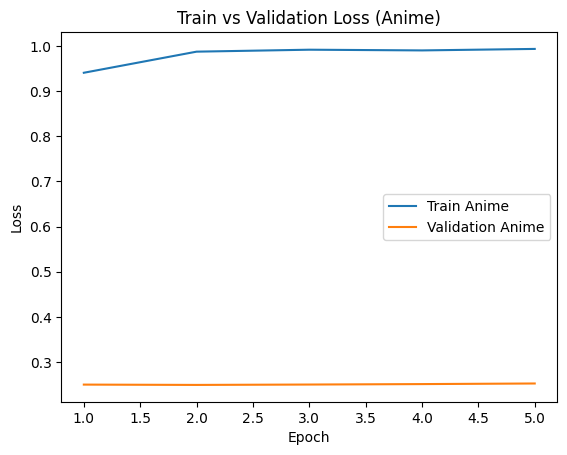

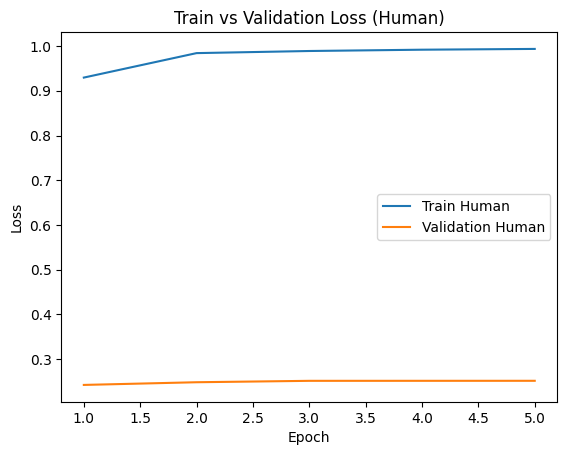

In [46]:
gan_model_path = get_model_name("loss", epoch=4, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
plot_training_curve(gan_model_path)